# Hamiltonian Flow Models



### Part 0: Miscellaneous Imports and Utility Functions
No questions here, but free to read through to familiarize yourself with these helper functions. Most of this is what you already completed in lab one!

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @property
    @abstractmethod
    def dim(self) -> int:
        """
        Returns:
            - Dimensionality of the distribution
        """
        pass

    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass

class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0])
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

class MoonsSampleable(Sampleable):
    """
    Implementation of the Moons distribution using sklearn's make_moons
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale: float = 5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: Standard deviation of Gaussian noise added to the data
            scale: How much to scale the data
            offset: How much to shift the samples from the original distribution (2,)
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: Number of samples to generate
        Returns:
            torch.Tensor: Generated samples with shape (num_samples, 3)
        """
        samples, _ = make_moons(
            n_samples=num_samples,
            noise=self.noise,
            random_state=None  # Allow for random generation each time
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CirclesSampleable(Sampleable):
    """
    Implementation of concentric circle distribution using sklearn's make_circles
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale=5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        samples, _ = make_circles(
            n_samples=num_samples,
            noise=self.noise,
            factor=0.5,
            random_state=None
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CheckerboardSampleable(Sampleable):
    """
    Checkboard-esque distribution
    """
    def __init__(self, device: torch.device, grid_size: int = 3, scale=5.0):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.grid_size = grid_size
        self.scale = scale
        self.device = device

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0,2).to(device)
        while samples.shape[0] < num_samples:
            # Sample num_samples
            new_samples = (torch.rand(num_samples,2).to(self.device) - 0.5) * 2 * self.scale
            x_mask = torch.floor((new_samples[:,0] + self.scale) / grid_length) % 2 == 0 # (bs,)
            y_mask = torch.floor((new_samples[:,1] + self.scale) / grid_length) % 2 == 0 # (bs,)
            accept_mask = torch.logical_xor(~x_mask, y_mask)
            samples = torch.cat([samples, new_samples[accept_mask]], dim=0)
        return samples[:num_samples]

In [3]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])

    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu(), y=samples[:,1].cpu(), ax=ax, **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

### Hamiltonian Generative Flows
**Proposition 3** from [1]:
*Let $\pi_T$ be the distribution such that $x_T^\theta \sim \pi_T$. Let $V_\phi^*$ be the Hamiltonian Velocity Predictor. Then by sampling $x_T \sim \pi_T$ and running the **velocity prediction ODE**
$$\frac{d}{dt}x(t) = V_{\phi^*}(x, t) \implies x(0) \sim \pi$$
backwards in time, we will have $x(0) \sim \pi$. i.e. we can sample from the data distribution $\pi$. More specifically, the optimal velocity predictor $V_{\phi^*}$ generates the probability path $\phi(\cdot, t)$.*

To make this proposition into a model, we need to specify the Hamiltonian Velocity Predictor. First we should specify what Hamiltonian Flow means. Here a flow of the state $\varphi = (x, v)$ is Hamiltonian if it follows the following differential equation
$$\frac{d\varphi}{dt} = (v(x, t), F(x, v, t))$$
The optimial velocity predictor minimizes the loss
$$L_v(\phi, t) = \mathbb{E}_{(x, v) \sim \Pi}\left[\left\lVert V_\phi(x_t, t) - v_t\right\rVert^2\right]$$

Since we are primarily interested in analytic solutions to these equations, we can assume that given an $x(0) \sim \pi$ from the data distribution we can generate $(x(t), v(t)) \sim \Pi(t)$ for training. Sampling will require us to step backwards in time rather than forwards.

The central object of study will be the Hamiltonian probability path, which we have to sample from. This object is denoted as $\Pi(t)$ above.

In [4]:
class HamiltonianProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for Hamiltonian probability paths
    """
    def __init__(self, p_velocity: Sampleable, p_initial: Sampleable, p_final: Sampleable):
        super().__init__()
        self.p_initial = p_initial
        self.p_velocity = p_velocity
        self.p_final = p_final

    def sample_path(self, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples from the hamiltonian probability path
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        num_samples = t.shape[0]
        x_0 = self.p_initial.sample(num_samples)
        v_0 = self.p_velocity.sample(num_samples)
        return self.simulate_trajectory(x_0, v_0, t)

    @abstractmethod
    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        pass

    def sample_final(self, num_samples: int) -> torch.Tensor:
        """
        Samples from the final distribution p_final
        Args:
            - num_samples: Number of samples to generate
        Returns
            - x_T: the final value of x (num_samples, dim)
        """
        return self.p_final.sample(num_samples)

# Diffusion Models as HGFs
---
Here we let $F = 0$ in the Hamiltonian flow, which means that $v(t) = v_0$ is constant and $x(t) = x_0 + vt$. $\Pi(x, v) = \pi(x) \bigotimes N(0, \mathbf{I}_d)$. The training objective is
$$L_v(\phi, t) = \mathbb{E}_{v_0 \sim N(0, \mathbf{I}_d)}\left[\left\lVert V_\phi(x_0 + vt) - v_0\right\rVert^2\right]$$

The final distribution is $N(0, t^2\mathbf{I}_d)$ as $t \rightarrow \infty$.

In [5]:
class DiffusionProbabilityPath(HamiltonianProbabilityPath):
    """
    Class for Diffusion probability paths
    """
    def __init__(self, p_data: Sampleable, T_final: float):
        p_velocity = Gaussian.isotropic(dim=2, std=1.0).to(device)
        p_final = Gaussian.isotropic(dim=2, std=T_final).to(device)
        super().__init__(p_velocity, p_data, p_final)

    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        return x_0 + v_0 * t, v_0

In [6]:
PARAMS = {
    "scale": 10.0,
    "target_std": 0.1,
    "target_scale": 5.0,
    "T_final": 3.0
}

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


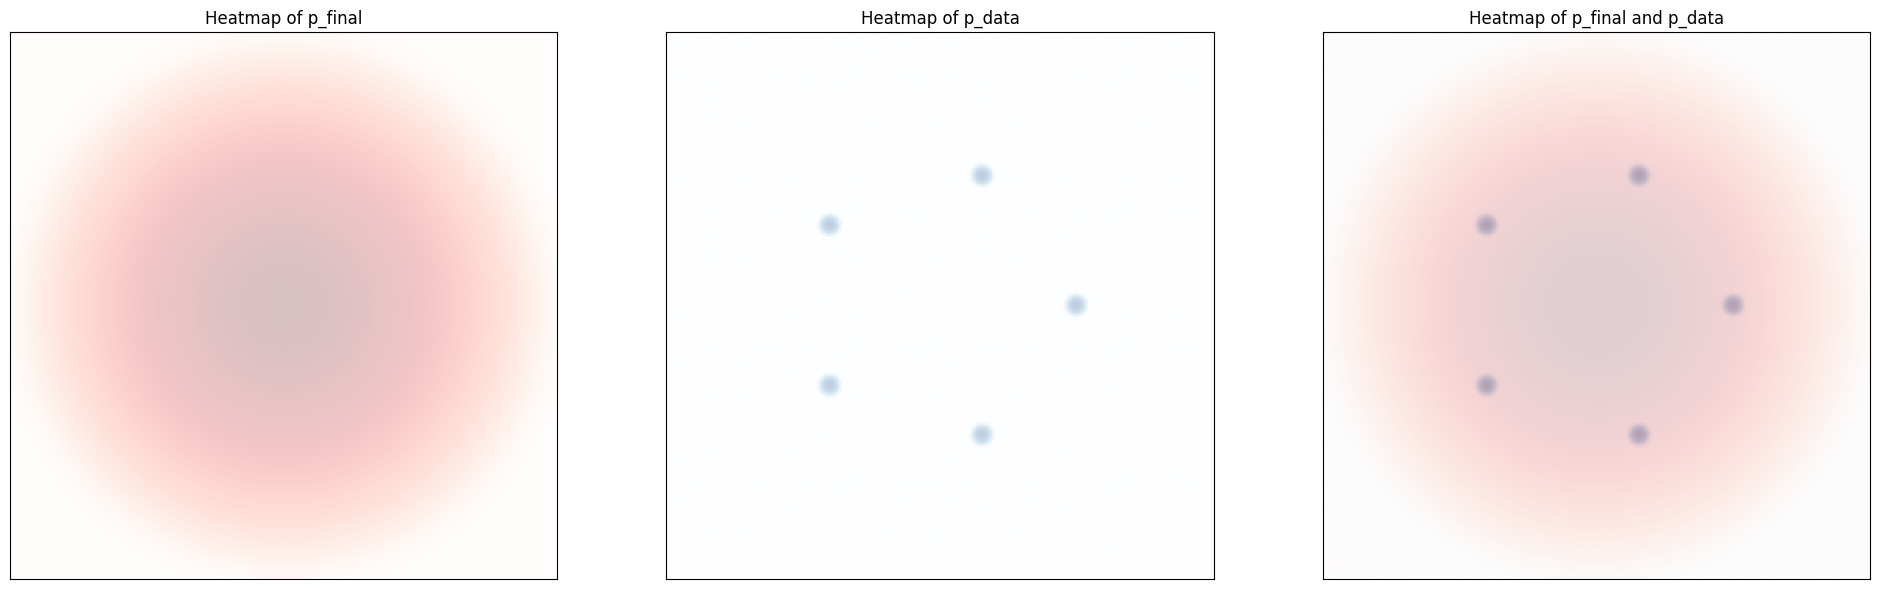

In [7]:
p_simple = Gaussian.isotropic(dim=2, std = 1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS['target_std'], scale=PARAMS['target_scale']).to(device)
p_final = Gaussian.isotropic(dim=2, std=PARAMS['T_final']).to(device)

fig, axes = plt.subplots(1,3, figsize=(24,8))
bins = 200

scale = PARAMS['scale']
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

axes[0].set_title('Heatmap of p_final')
axes[0].set_xticks([])
axes[0].set_yticks([])
imshow_density(density=p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[0], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))


axes[1].set_title('Heatmap of p_data')
axes[1].set_xticks([])
axes[1].set_yticks([])
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[1], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

axes[2].set_title('Heatmap of p_final and p_data')
axes[2].set_xticks([])
axes[2].set_yticks([])
imshow_density(density=p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

We'll train a simple MLP to fit optimize the velocity predictor.

In [8]:
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)

Let's first define a general-purpose class `Trainer` to keep things tidy as we start training.

In [9]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

        # Finish
        self.model.eval()

`VelocityMatchingTrainer.get_train_loss`: this function should implement the conditional flow matching objective
$$L_v(\phi, t) = \mathbb{E}_{v_0 \sim N(0, \mathbf{I}_d)}\left[\left\lVert V_\phi(x_0 + vt) - v_0\right\rVert^2\right]$$
Here, $N$ is our *batch size*.

In [10]:
class VelocityMatchingTrainer(Trainer):
    def __init__(self, path: HamiltonianProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int, T: float) -> torch.Tensor:
        t = torch.rand(batch_size, 1) * T
        x, v = self.path.sample_path(t)
        u_theta = self.model(x, t)
        return torch.mean((u_theta - v) ** 2)

Now let's train! This may take about a minute... **Remember, the loss should converge, but not to zero!**

In [11]:
# Construct conditional probability path
path = DiffusionProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    T_final = PARAMS["T_final"]
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = VelocityMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000, T=3)

Epoch 4999, loss: 0.3073881268501282: : 5000it [00:55, 90.83it/s]


To test the model we have to make the forward and reverse integrators.

In [12]:
class ODE(ABC):
    @abstractmethod
    def velocity(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

class LearnedVectorFieldODE(ODE):
    def __init__(self, net: MLPVectorField):
        self.net = net

    def velocity(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - xt: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        return self.net(xt, t)

class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (bs,1)
            - dt: time, shape (bs,1)
        Returns:
            - nxt: state at time t + dt (bs, dim)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (bs, num_timesteps,1)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.ode.velocity(xt,t) * h

def record_every(num_timesteps: int, record_every_num: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every_num parameter
    """
    if record_every_num == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every_num),
            torch.tensor([num_timesteps - 1]),
        ]
    )

100%|██████████| 999/999 [00:01<00:00, 669.29it/s]


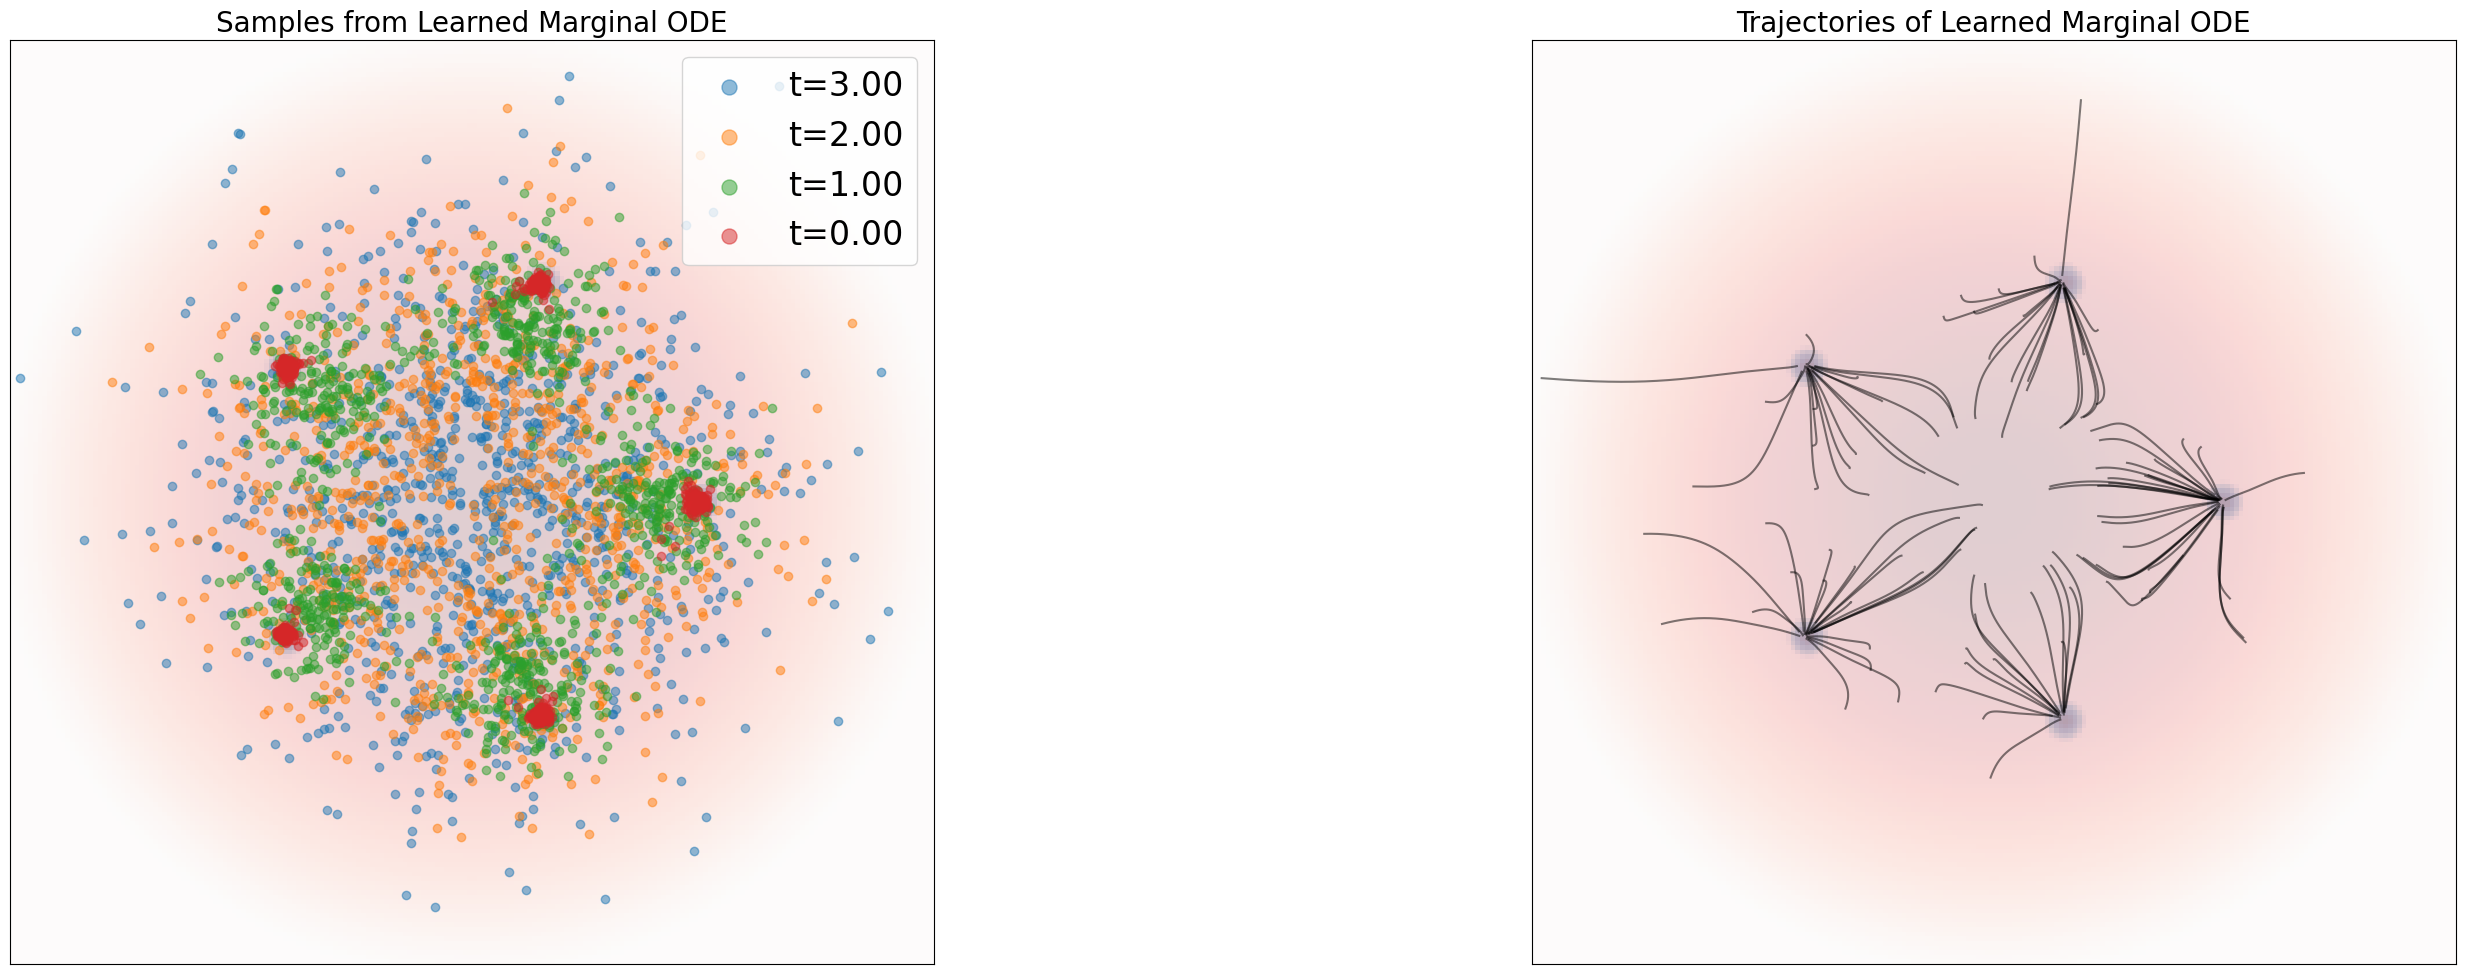

In [13]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3
T_final = 3

##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_final.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(T_final, 0.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every_num=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[1]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

### Flow Matching as HGFs



Another approach is to take a different initial distribution. If we take $x \sim \pi$ and $v = \epsilon - x$ with $\epsilon \sim N(0, \mathbf{I}_d)$, then we can integrate $x(t) = x_0 + v_0 t = x_0(1 - t) + t\epsilon$. Then $x(0) = x_0$ and $x(1) = \epsilon$.

In [14]:
class FlowProbabilityPath(HamiltonianProbabilityPath):
    """
    Class for Diffusion probability paths
    """
    def __init__(self, p_data: Sampleable):
        epsilon = Gaussian.isotropic(dim=2, std=1.0).to(device)
        p_final = Gaussian.isotropic(dim=2, std=1.0).to(device)
        super().__init__(epsilon, p_data, p_final)

    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        return x_0 * (1 - t) + v_0 * t, v_0 - x_0

In [15]:
# Construct conditional probability path
path = FlowProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = VelocityMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000, T=1)

Epoch 4999, loss: 4.278944492340088: : 5000it [00:55, 90.35it/s]


Now let's train! **Remember, the loss should converge, but not to zero!**

100%|██████████| 999/999 [00:01<00:00, 678.44it/s]


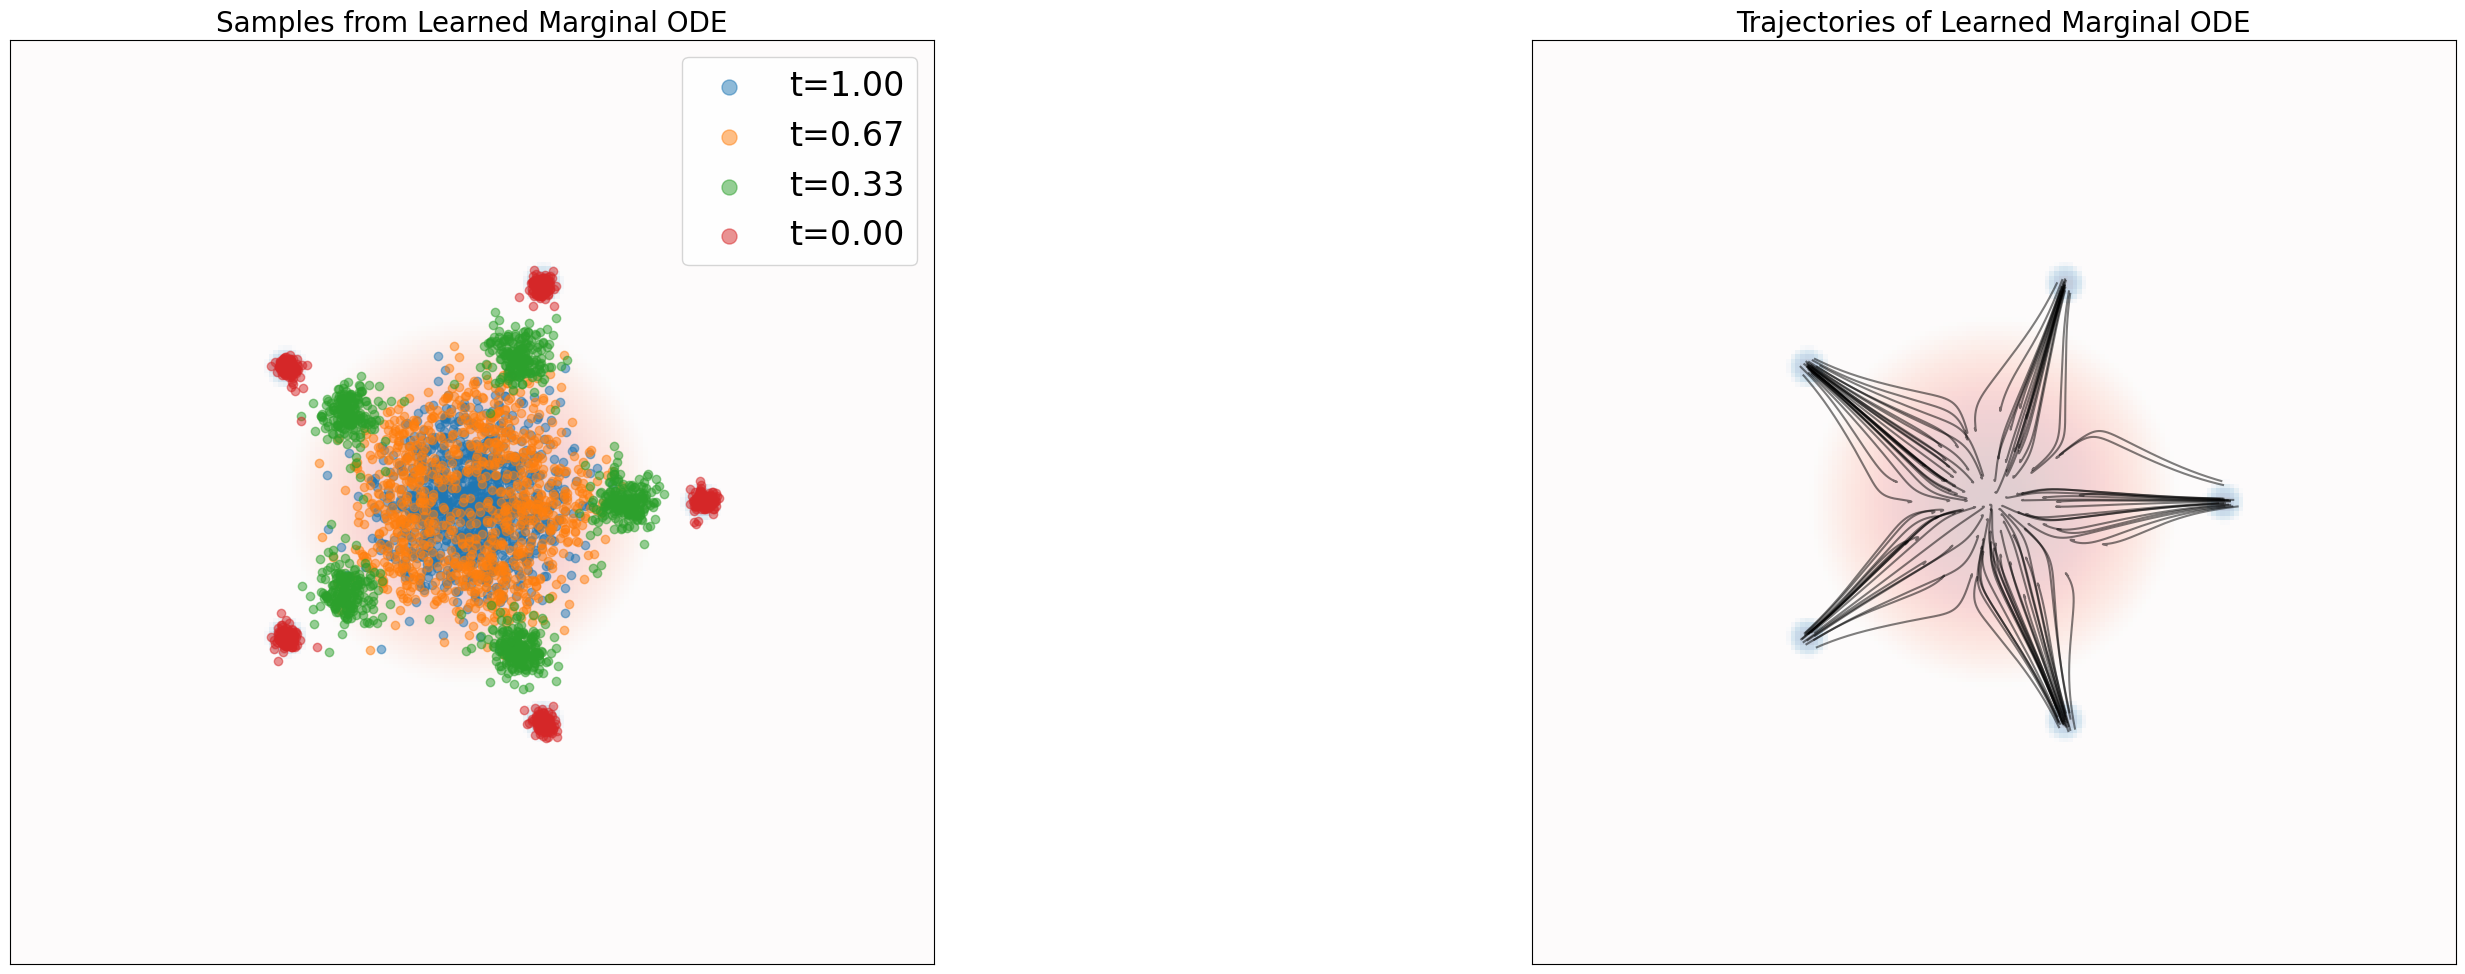

In [16]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3
T_final = 1.0

##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_final.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(T_final, 0.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every_num=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[1]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

### Oscillation HGFs

The previous two cases were HGFs that were essentially rehashes of previous diffusion works. In this third case, the force $F = -\alpha^2 x$. The sampling distribution is now $\Pi = \pi ⊗ N(0, \mathbf{I}_d)$, and the trajectory for this ODE is the harmonic oscillator:
$$ (x_t, v_t) = \left(\cos(\alpha t)x + \frac{1}{\alpha}\sin(\alpha t)v, -\alpha\sin(\alpha t)x + \cos(\alpha t)v\right)$$

For this trajectory it can be seen that at $T = \pi/(2\alpha)$ we have $(x(T), v(T)) = \left(\frac{v}{\alpha}, -\alpha x\right)$. To simplify the algebra we can set $\alpha = 1$. This means $x(\pi / 2) \sim N(0, \mathbf{I}_d)$

In [17]:
class OscillationProbabilityPath(HamiltonianProbabilityPath):
    """
    Class for Diffusion probability paths
    """
    def __init__(self, p_data: Sampleable):
        epsilon = Gaussian.isotropic(dim=2, std=1.0).to(device)
        p_final = Gaussian.isotropic(dim=2, std=1.0).to(device)
        super().__init__(epsilon, p_data, p_final)

    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        return torch.cos(t) * x_0 + torch.sin(t) * v_0, -torch.sin(t) * x_0 + torch.cos(t) * v_0

In [23]:
# Construct conditional probability path
path = OscillationProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

T_final = np.pi / 2
# Construct trainer
trainer = VelocityMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000, T=T_final)

Epoch 4999, loss: 2.6582517623901367: : 5000it [01:01, 81.09it/s]


100%|██████████| 999/999 [00:01<00:00, 674.79it/s]


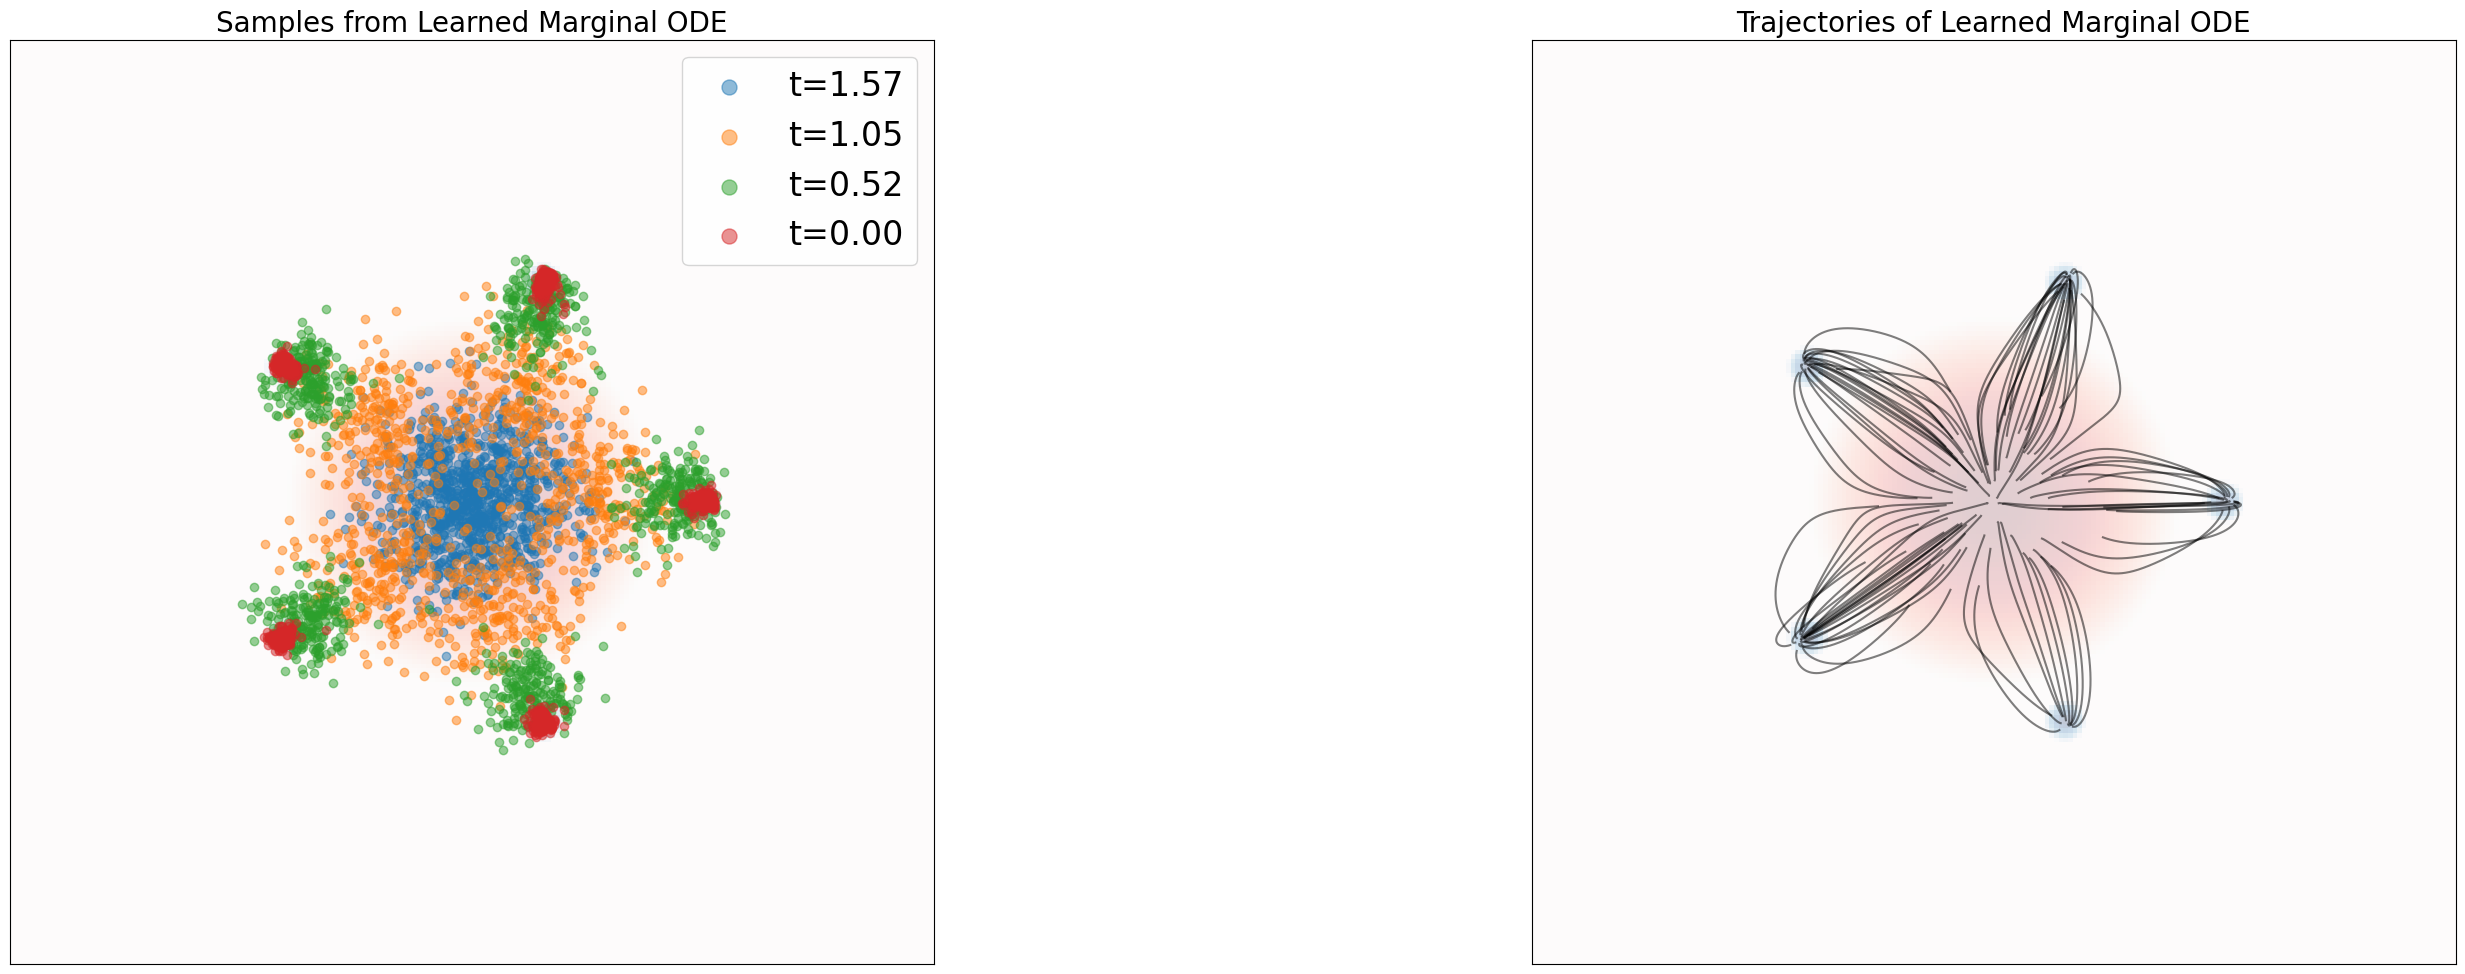

In [24]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3

##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_final.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(T_final, 0.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every_num=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[1]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

### Let's try it with a different data distribution.

In [26]:
# Construct conditional probability path
path = OscillationProbabilityPath(
    p_data = MoonsSampleable(device=device),
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = VelocityMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000, T=T_final)

Epoch 4999, loss: 3.284818172454834: : 5000it [00:54, 90.97it/s] 


100%|██████████| 999/999 [00:01<00:00, 713.88it/s]


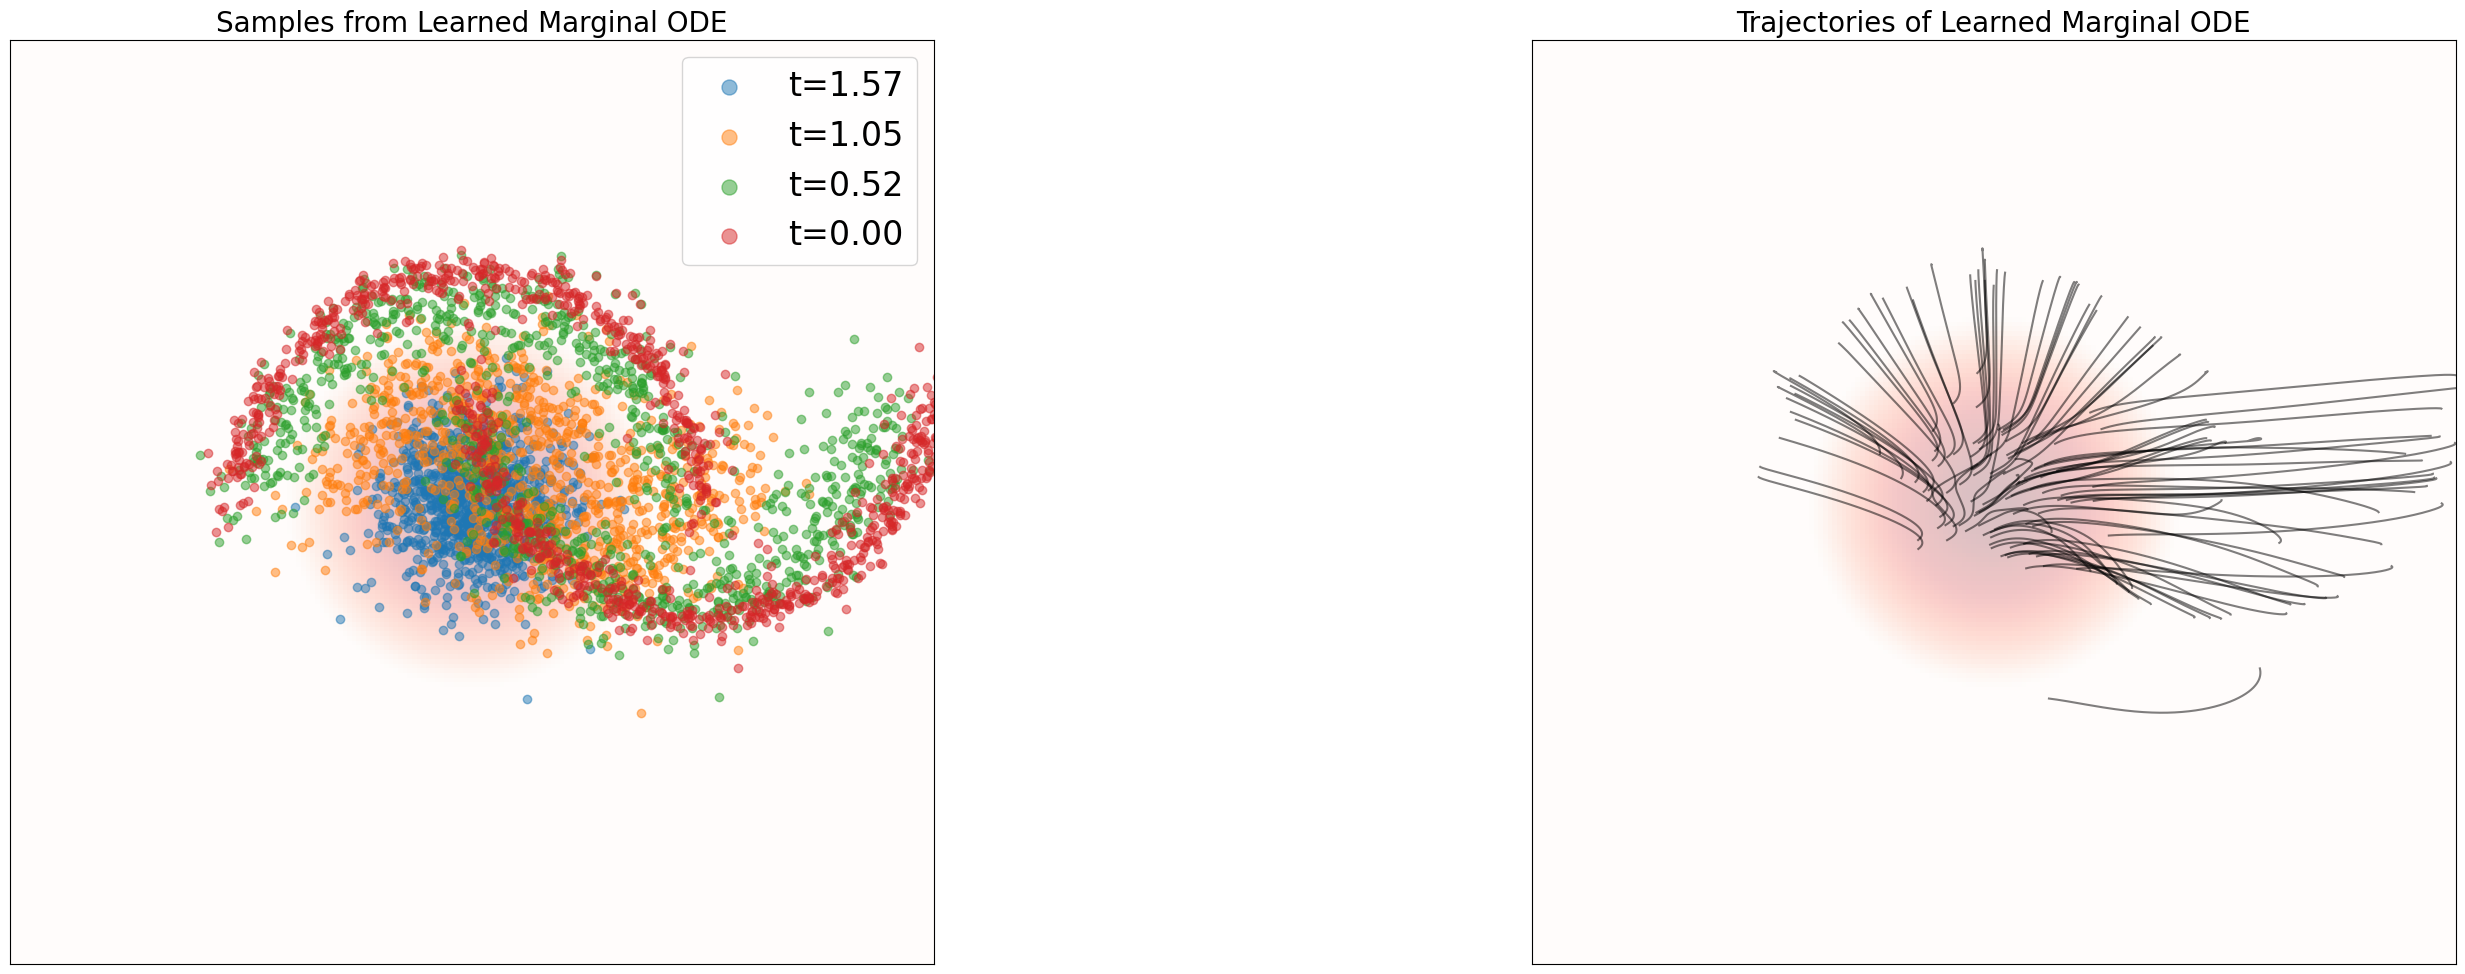

In [27]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3

##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_final.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(T_final, 0.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every_num=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[1]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_final, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

[1] *Hamiltonian Score Matching and Generative Flows*,

Holderrieth, P., Xu, Y., Jaakkola, T.,

The Thirty-eighth Annual Conference on Neural Information Processing Systems 2024,
https://openreview.net/forum?id=JJGfCvjpTV